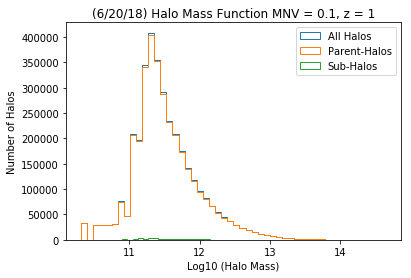

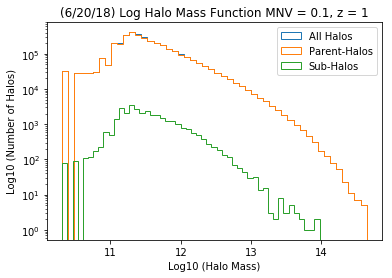

In [35]:
# -*- coding: utf-8 -*-

# Processes Halo Data from Halo Catalogs

import sys, os
import numpy as np
from matplotlib import pyplot as plt
from halotools import sim_manager
import h5py
from scipy import fftpack
from scipy.fftpack import fftfreq, fftshift, ifftshift, ifftn
#from emcee.utils import MPIPool

Lbox = 512.0 # size of box in Mpc/h
Ngrid = 256.0 # number of cells in 1D of grid for power spectrum

bin_centers = np.arange(Ngrid) # integer linear space up to number of cells for as bin centers
Lgrid = Lbox / Ngrid # the size of each individual grid cell

# directories, sub directories, and out list files for subhalo and parent halo catelogs
subhalo_main_dir = "~/temp/"
subhalo_cosmo_tup = ("mnv0.00000_om0.30000_As2.1000/", "mnv0.10000_om0.30000_As2.1000/", "mnv0.60000_om0.30000_As2.1000/")
subhalo_out_tup = ("out_37.list", "out_42.list", "out_47.list", "out_56.list", "out_66.list")

parent_main_dir = "/tigress/ayannam/"
parent_cosmo_tup = ("mnv_0.0", "mnv_0.1", "mnv_0.6")
subhalo_out_tup = ("out_37_parents.list", "out_42_parents.list", "out_47_parents.list", "out_56_parents.list", "out_66_parents.list")

headers_str = "#ID DescID Mvir Vmax Vrms Rvir Rs Np X Y Z VX VY VZ JX JY JZ Spin rs_klypin Mvir_all M200b M200c M500c M2500c Xoff Voff spin_bullock b_to_a c_to_a A[x] A[y] A[z] b_to_a(500c) c_to_a(500c) A[x](500c) A[y](500c) A[z](500c) T/|U| M_pe_Behroozi M_pe_Diemer Halfmass_Radius PID"
headers_tup = tuple(headers_str.split(" "))

columns_dict ={
		"halo_id": 	(0, 'i8'),
		"halo_mvir": 	(2, 'f4'),
		"halo_x": 	(8, 'f4'),
		"halo_y": 	(9, 'f4'),
		"halo_z": 	(10,'f4'),
		"PID":		(41,'i8')
	       }

#def read_cat(cat_filename):
   # returns a matrix with each halo as the row and x, y, z positions as the columns, array of the log10 of the halo masses, and the PID array
   # must use 3D accessing to access postions and 2D accessing to access the masses where the second dimension is the halo
   #reader = sim_manager.TabularAsciiReader(cat_filename, columns_dict)
   #halo_arr = reader.read_ascii() # array of tuples containing values for each item in columns_dict
   #halo_pos_arr = np.array([halo_arr["halo_x"], halo_arr["halo_y"], halo_arr["halo_z"]]).T #array of arrays containing the x, y, z positions of the halo
   #halo_mass_arr = np.log10(halo_arr["halo_mvir"]) # array of log base 10 of the halo masses
   
   #halo_PID_arr = np.array(halo_arr["PID"])
   #return halo_pos_arr, halo_mass_arr, halo_PID_arr


def plot_halo_mass(mass_filename, PID_filename):
    
    mass_arr = np.load(mass_filename)
    PID_arr = np.load(PID_filename)
   
    parents_mask = PID_arr == -1 # boolean array with True for parent halos and False for subhalos
    subhalo_mask = PID_arr != -1 # boolean array with True for subhalos and False for parent halos
    
    plt.hist(mass_arr, bins = 50, label = "All Halos", histtype = "step") # plots mass function of all of the halos
    plt.hist(mass_arr[parents_mask], bins = 50, label = "Parent-Halos", histtype = "step") # plots the mass function of the parent halos
    plt.hist(mass_arr[subhalo_mask], bins = 50, label = "Sub-Halos", histtype = "step") # plots the mass function of the subhalos

    plt.title("(6/20/18) Halo Mass Function MNV = 0.1, z = 1")
    plt.xlabel("Log10 (Halo Mass)")
    plt.ylabel("Number of Halos")
    plt.legend()
    plt.show()

    plt.hist(mass_arr, bins = 50, label = "All Halos", histtype = "step") # plots mass function of all of the halos
    plt.hist(mass_arr[parents_mask], bins = 50, label = "Parent-Halos", histtype = "step") # plots the mass function of the parent halos
    plt.hist(mass_arr[subhalo_mask], bins = 50, label = "Sub-Halos", histtype = "step") # plots the mass function of the subhalos
   
    plt.title("(6/20/18) Log Halo Mass Function MNV = 0.1, z = 1")
    plt.xlabel("Log10 (Halo Mass)")
    plt.ylabel("Log10 (Number of Halos)")
    plt.yscale('log')
    plt.legend()
    plt.show()
    
plot_halo_mass("/u/ayannam/Documents/Raw_Data/mnv_0.1/out_47_parents_mass.npy", "/u/ayannam/Documents/Raw_Data/mnv_0.1/out_47_parents_PID.npy")

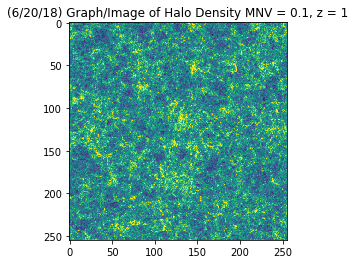

In [36]:
def plot_grid(grid_filename):
    g = np.load(grid_filename)
    plt.imshow(np.sum(g, axis = 0), vmin = -3 * np.std(np.sum(g, axis = 0)), vmax = 3 * np.std(np.sum(g, axis = 0)))
    plt.title("(6/20/18) Graph/Image of Halo Density MNV = 0.1, z = 1")
    plt.show()
    
plot_grid("/u/ayannam/Documents/Grids/mnv_0.1/out_47_parents_grid.npy")

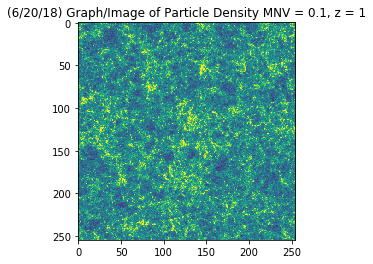

In [37]:
def read_subsample (subsample_fn, dataset_name='Subsample'):
    '''Read the subsampled dark matter particles
    Input:
    subsample_fn = is the input filename, e.g. subsample_fn=main_dir+cosmo_arr[0]+subsample_file_arr[0]
    Output:
    particle_pos: 3d array, the x,y,z position of the particles, in unit of Mpc/h
    '''
    f=h5py.File(subsample_fn,'r')
    dataset = f[dataset_name]
    particle_pos = dataset['Position']/1e3
    return particle_pos

def gridding(halo_positions):
    # returns a 3D grid of the density of halos
    grid = np.histogramdd(halo_positions / Lgrid, bins = [bin_centers, bin_centers, bin_centers])[0]
    grid = grid / np.mean(grid) - 1
    return grid

p = read_subsample("/u/ayannam/Documents/Test_Files/snapshot_047_idmod_101_0.hdf5")
g = gridding(p)
plt.imshow(np.sum(g, axis = 0), vmin = -3 * np.std(np.sum(g, axis = 0)), vmax = 3 * np.std(np.sum(g, axis = 0)))
plt.title("(6/20/18) Graph/Image of Particle Density MNV = 0.1, z = 1")
plt.show()

/u/ayannam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


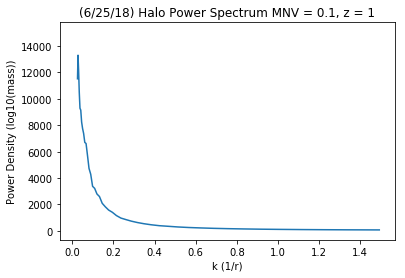

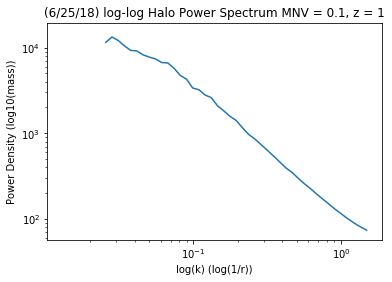

In [38]:
def azimuthalAverage3D(grid, edges = None, logbins = True, bins = 50):
    z, y, x = np.indices(grid.shape)
    icenter=(x.max()-x.min())/2.0
    center = np.array([icenter, icenter, icenter])
     
    if grid.shape[0]%2 == 0:
        center+=0.5
     
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2)#distance to center pixel, for each pixel
 
    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind] # the index to sort by r
    i_sorted = grid.flat[ind] # the index of the images sorted by r
 
    # find index that's corresponding to the lower edge of each bin
    kmin=1.0
    kmax=grid.shape[0]/2.0
    if edges == None:
        if logbins:
            edges = np.logspace(np.log10(kmin),np.log10(kmax),bins+1)
        else:
            #edges = linspace(kmin,kmax+0.001,bins+1)    
            edges = np.linspace(kmin,kmax,bins+1)
    if edges[0] > 0:
        edges = np.append([0],edges)
         
    hist_ind = np.histogram(r_sorted,bins = edges)[0] # hist_ind: the number in each ell bins, sum them up is the index of lower edge of each bin, first bin spans from 0 to left of first bin edge.    
    hist_sum = np.cumsum(hist_ind)
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[hist_sum[1:]] - csim[hist_sum[:-1]]
    radial_prof = tbin / hist_ind[1:]
    return edges[1:], radial_prof

edge2center = lambda x: x[:-1]+0.5*(x[1:]-x[:-1])

def PowerSpectrum3D(grid, logbins = True, bins=50):
    # Calculate the power spectrum for a cube.
    # Input:
    # grid = input grid in numpy array.
    # Output:
    # k, psd1D
    isize = grid.shape[0]
    F = fftshift(fftpack.fftn(grid))
    psd3D = np.abs(F)**2
    k_arr, psd1D = azimuthalAverage3D(psd3D, logbins = logbins, bins=bins)
    k_arr = edge2center(k_arr)
    return k_arr, psd1D
 
def process_ps(grid_filename):
    '''
    Comoput the power spectrum giving the positions of particles/halos.
    Input:
    The positions, output from either read_cat, or read_subsample
    Output: 
    k_normed: the k bin center
    ps3d_normed: the power spectrum
    '''
    igrid = np.load(grid_filename)
    k, ps3d = PowerSpectrum3D(igrid)
    k_normed, ps3d_normed = 2*np.pi*k/Lbox, ps3d*(Lgrid/Ngrid)**3
    return k_normed, ps3d_normed

def plot_power_spectrum(grid_filename):
    
    k, p = process_ps(grid_filename)
    
    plt.plot(k, p)
    plt.title("(6/25/18) Halo Power Spectrum MNV = 0.1, z = 1")
    plt.xlabel("k (1/r)")
    plt.ylabel("Power Density (log10(mass))")
    plt.show()
    
    plt.plot(k, p)
    plt.title("(6/25/18) log-log Halo Power Spectrum MNV = 0.1, z = 1")
    plt.xlabel("log(k) (log(1/r))")
    plt.ylabel("Power Density (log10(mass))")
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

plot_power_spectrum("/u/ayannam/Documents/Grids/mnv_0.1/out_47_parents_grid.npy")